In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
y, sr = librosa.load("voice.wav")
#sr = 22050
#df = np.linspace(440, 880, sr*4)
#f = np.cumsum(df/sr)
#y = np.cos(2*np.pi*f)
ipd.Audio(y, rate=sr)

/home/ctralie/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/ctralie/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/ctralie/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


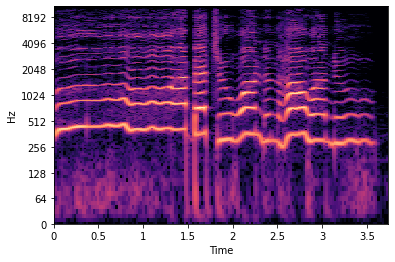

In [3]:
hop_length = 512
win_length = 2048
S = np.abs(librosa.stft(y, hop_length=hop_length, win_length=win_length))
librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),sr=sr, y_axis='log', x_axis='time')

Text(0, 0.5, 'Note number')

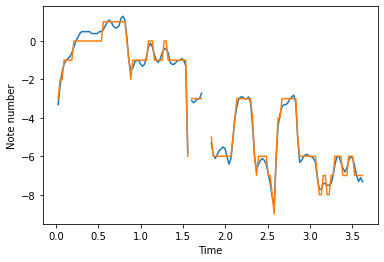

In [4]:
maxfreqs, voiced_flag, voiced_probs = librosa.pyin(y, 80, 4000, sr=sr, hop_length=hop_length)
maxfreqs_round = 440*2**(np.round(12*np.log2(maxfreqs/440))/12)
times = np.arange(len(maxfreqs))*hop_length/sr
plt.plot(times, np.log2(maxfreqs/440)*12)
plt.plot(times, np.log2(maxfreqs_round/440)*12)
plt.xlabel("Time")
plt.ylabel("Note number")

In [5]:
N = len(maxfreqs)
df = np.zeros(N*hop_length)
t = np.arange(hop_length)/sr
for i, f in enumerate(maxfreqs):
    if np.isnan(f):
        f = 0
    df[i*hop_length:(i+1)*hop_length] = f
f = np.cumsum(df)/sr
x = np.cos(2*np.pi*f)
x = np.sign(x)*np.abs(x)**0.5
ipd.Audio(x, rate=sr)

In [6]:
from spectrogramtools import *

ratios = maxfreqs_round/maxfreqs
ratios[np.isnan(ratios)] = 1

S2 = np.zeros_like(S)
freqs = np.arange(S.shape[0])
for j in range(S.shape[1]):
    new_freqs = freqs/ratios[j]
    sj = np.abs(S[:, j])
    S2[:, j] = np.interp(new_freqs, freqs, sj)

yshift = griffinLimInverse(S2, win_length, hop_length)
ipd.Audio(yshift, rate=sr)

Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10
